In [13]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

import json 


from sklearn.metrics import accuracy_score, log_loss, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
import seaborn as sns

from joblib import parallel_backend
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from pandas.tools.plotting import scatter_matrix

from managing_utils import *

In [14]:
df = get_data()
df.head()

,robot_gear_compression_diff_1,weapon_robot_armour_index_2,robot_gear_compression_diff_3,robot_gear_compression_diff_4,weapon_robot_punch_right_1,robot_gear_compression_diff_6,robot_gear_compression_diff_7,robot_gear_compression_diff_8,robot_gear_compression_diff_9,robot_gear_compression_diff_10,robot_gear_circulation_1,robot_gear_circulation_2,weapon_robot_punch_left_3,weapon_robot_armour_index_5,weapon_robot_armour_index_3,robot_gear_circulation_6,weapon_robot_punch_right_4,robot_gear_circulation_8,weapon_robot_punch_right_2,weapon_robot_gun_power_4,weapon_robot_gun_power_5,robot_gear_circulation_12,robot_gear_circulation_13,robot_gear_circulation_14,robot_gear_circulation_15,weapon_robot_gun_power_3,weapon_robot_punch_left_5,robot_gear_circulation_18,robot_gear_circulation_19,robot_gear_circulation_20,robot_gear_circulation_21,weapon_robot_punch_right_5,robot_gear_coef_1,weapon_robot_gun_power_2,robot_gear_compression_1,robot_gear_compression_2,robot_gear_compression_3,weapon_robot_armour_index_4,weapon_robot_eye_laser_emission_1,robot_gear_compression_6,robot_gear_temperature_diff_1,robot_gear_temperature_diff_2,robot_gear_temperature_diff_3,weapon_robot_eye_laser_sensor_1,robot_gear_temperature_diff_5,robot_gear_temperature_diff_6,robot_gear_temperature_1,robot_gear_temperature_2,robot_gear_temperature_3,robot_gear_temperature_4,weapon_robot_eye_laser_emission_4,weapon_robot_punch_right_3,weapon_robot_gun_power_1,robot_gear_temperature_8,robot_gear_temperature_9,robot_gear_temperature_10,robot_gear_temperature_11,robot_gear_temperature_12,robot_gear_temperature_13,robot_gear_temperature_14,robotic_circuits_speed_1,robotic_circuits_speed_2,robotic_circuits_speed_3,robotic_circuits_speed_4,robotic_circuits_speed_5,robotic_circuits_speed_6,robotic_circuits_speed_12,robot_engine_speed_13,robot_engine_speed_14,robot_engine_speed_15,robot_engine_speed_16,robot_engine_circulation_2,robot_engine_circulation_3,robot_engine_circulation_4,robot_engine_circulation_6,robot_engine_circulation_7,robot_engine_circulation_8,robot_engine_ground_1,robot_engine_compression_1,robot_engine_compression_2,robot_engine_compression_3,weapon_robot_eye_laser_emission_2,robot_engine_temperature_2,robot_engine_temperature_3,robot_engine_temperature_4,robot_engine_temperature_5,robot_engine_temperature_6,weapon_robot_eye_laser_sensor_2,weapon_robot_punch_left_1,robot_engine_temperature_9,robot_engine_temperature_10,robot_engine_temperature_11,robot_engine_temperature_12,robot_engine_temperature_13,robot_engine_temperature_14,robot_engine_temperature_15,robot_engine_temperature_16,robot_engine_temperature_17,weapon_robot_eye_laser_range_2,weapon_robot_eye_laser_sensor_3,robot_engine_temperature_20,robot_engine_temperature_21,weapon_robot_eye_laser_emission_3,robot_engine_temperature_23,robot_engine_temperature_24,robot_engine_temperature_25,robot_engine_temperature_26,robot_engine_temperature_27,robot_engine_temperature_28,robot_probe_compression_diff_1,robot_probe_compression_diff_2,robot_probe_compression_diff_3,robot_probe_compression_diff_4,robot_probe_compression_diff_5,robot_probe_compression_diff_6,robot_probe_compression_diff_7,robot_probe_compression_diff_8,robot_probe_compression_diff_9,robot_probe_compression_diff_10,robot_probe_circulation_1,robot_probe_circulation_2,robot_probe_circulation_3,robot_probe_circulation_4,robot_probe_circulation_5,robot_probe_circulation_6,robot_probe_circulation_7,weapon_robot_armour_index_1,robot_probe_circulation_9,robot_probe_circulation_10,robot_probe_circulation_11,robot_probe_circulation_12,robot_probe_temperature_1,robot_probe_temperature_2,robot_probe_temperature_3,weapon_robot_eye_laser_sensor_4,robot_probe_temperature_5,robot_probe_temperature_6,robot_probe_temperature_7,robot_probe_temperature_8,robot_probe_temperature_9,weapon_robot_eye_laser_range_1,weapon_robot_punch_left_4,weapon_robot_punch_left_2,gamma_ray,target
0,14.022325,13.997181,15.184937,9.143568,16.518011,11.032224,19.134443,12.103030,-

## Train mlp 

Создавать все модели меняя эту функцию не самая лучшая идея, поэтому когда делаете новую модель лучше всего написать новую функцию аналагичную этой (да и вообще лучше целую секцию)

In [15]:
def create_model(n_cols):
    model = Sequential()

    model.add(Dense(128, activation='relu', input_shape=(n_cols,), kernel_initializer='normal'))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dense(1, activation='linear'))
    return model

r2 metric 

${R^2 = \frac{\sum{(y_i - \hat{y_i})^2}}{\sum{(y_i - \bar{y})^2}}}$

${\hat{y_i}}$ -- предсказанное значение 
${\bar{y}}$ -- среднее значение 

In [16]:
X_train, y_train, X_test, y_test = split_train_test(df, 600, 'simple')

verbose = 0 # выводить ли инфу в процессе обучения (на гитхаб лучше не заливать когда verbose > 0, а просто перетренировать с = 0, ну или если это долго то перед комитом очистить оутпуты)
            # 0 - silence 
            # 1 - progress bar
            # 2 - line per epoch 
model = create_model(X_train.shape[1])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[coeff_determination])
model.summary()
history = model.fit(X_train, y_train, validation_split=0.2, epochs=400, verbose=verbose)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               18560     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 249,217
Trainable params: 249,217
Non-trainable params: 0
_________________________________________________________________


Вся инфа про обучение лежит в history

In [17]:
history.history['val_coeff_determination'][-10:]

[0.9684065508797737,
 0.9692448909913398,
 0.9688925257766895,
 0.9676088335142797,
 0.9649802704689426,
 0.9655745160288927,
 0.96018564566886,
 0.9658777722721923,
 0.956757009141217,
 0.9672592929782832]

In [18]:
model.evaluate(X_test, y_test)

600/600 [==============================] - 0s 39us/step


[4.663284142812093, 0.9770452308654786]

In [16]:
save_model(model, 940, 'simple')

In [19]:
create_submition(model, subm_name='subm_mlp_250k.csv')

# train model on full dataset

In [21]:
def train_full_set(enc='simple', create_model=create_model, epochs=400, verbose=0):
    dataset = pd.read_csv('./robot_data/train_data.csv')    
    dataset = dataset.drop(columns=['year'])
    dataset = dataset.sample(frac=1).reset_index(drop=True)
    X_train, y_train, X_test, y_test = split_train_test(dataset, 0, enc)
    model = create_model(X_train.shape[1])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[coeff_determination])
    model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, verbose=verbose)
    return model 

In [19]:
model = train_full_set()

#model.evaluate(X_train, y_train)

# try learn not only nn's

In [22]:
regressors = [
    Lasso(),
    ElasticNet(),
    DecisionTreeRegressor(),
    KNeighborsRegressor(),
    GradientBoostingRegressor()]

In [39]:
dataset = pd.read_csv('./robot_data/train_data.csv') 
dataset = dataset.sample(frac=1).reset_index(drop=True)

скейлим датасет и сопоставляем значения категориям 

In [40]:
dataset.head()

,year,robot_gear_compression_diff_1,weapon_robot_armour_index_2,robot_gear_compression_diff_3,robot_gear_compression_diff_4,weapon_robot_punch_right_1,robot_gear_compression_diff_6,robot_gear_compression_diff_7,robot_gear_compression_diff_8,robot_gear_compression_diff_9,...,robot_probe_temperature_5,robot_probe_temperature_6,robot_probe_temperature_7,robot_probe_temperature_8,robot_probe_temperature_9,weapon_robot_eye_laser_range_1,weapon_robot_punch_left_4,weapon_robot_punch_left_2,gamma_ray,target
0,3777,13.493252,13.203419,15.945541,35.322252,18.592792,11.956559,17.916364,17.653934,29.217912,...,2.887527,3.375930,-3.963133,2.921440,2.784923,1.625606,-0.647793,-6.832971,moderate,11.003709
1,3046,14.709268,14.705437,15.653622,13.795657,20.971365,10.914678,17.425029,15.206950,-11.543944,...,-19.334498,-0.451702,1.413641,3.267479,1.614526,1.457636,-11.378422,-151.100608,moderate,17.397085
2,3283,5.833995,6.604345,2.363601,-9.255311,3.541783,4.677368,3.419846,1.931145,-30.113728,...,-5.100160,3.108840,0.063384,3.092837,1.523644,1.486983,8.420694,24.461809,moderate,8.540650
3,4044,14.333394,13.808201,18.681990,51.246458,16.837010,12.740874,19.103214,18.158152,51.639965,...,8.315876,5.501720,0.966053,2.845833,0.952207,1.255815,-12.785290,-24.363242,moderate,8.575114
4,2343,15.439611,17.005719,16.209157,-1.440918,11.172942,8.459881,12.834418,4.049231,-35.656869,...,4.229461,-0.969258,-0.424363,3.010421,1.267441,0.792707,-26.840969,48.354919,low,18.487426


In [ ]:
dataset = simple_encode(dataset)

X = dataset.values[0::, 1:-1:]
y = dataset.values[0::, -1]

#scaler = StandardScaler()

#X = scaler.fit_transform(X)
#X = np.c_[(X, dataset.values[0::, -2])]

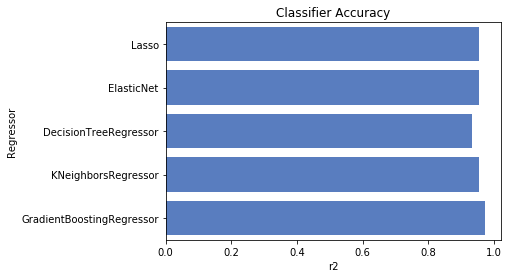

In [25]:
log_cols = ["Regressor", "r2"]
log = pd.DataFrame(columns=log_cols)

acc_dict = {}

for reg in regressors:
    name = reg.__class__.__name__
    
    acc = cross_validate(reg, X, y, scoring=['r2', 'neg_mean_squared_error'], cv=3, n_jobs=-1)
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc

for reg in acc_dict:
    log_entry = pd.DataFrame([[reg, acc_dict[reg]['test_r2'].mean()]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='r2', y='Regressor', data=log, color="b")

# train gradiend boosting regressor

Вообще этот регрессор выглядит многообещающе, но я потратил на него уже три попытки и все были с отрицательным r2 -> я както неправильно подготавливаю данные. Скорее всего я где-то неправ со scaler'ом. А мб он прост не работает и не надо тратить на него время

In [47]:
X_train, X_test = X[600:], X[:600]
y_train, y_test = y[600:], y[:600]


In [42]:
gbr_reg = GradientBoostingRegressor()
gbr_reg.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [43]:
y_preds = gbr_reg.predict(X_test)

In [44]:
gbr_reg.score(X_test, y_test)

0.9923531001197886

In [46]:

test_set = pd.read_csv('./robot_data/test_data.csv')
years = test_set['year']

test_set = test_set.drop(columns=['year', 'target'])
test_set = simple_encode(test_set)
#print(test_set.head())
y_pred = gbr_reg.predict(test_set)
y_pred = y_pred.reshape(1000)


d = {'year': years.values, 'target': y_pred}
ans = pd.DataFrame(d)
ans = ans.set_index('year')

ans.to_csv('./submissions/subm_gbr.csv')

# Train mlp w\ dropout

In [10]:

def create_dropout_model(n_cols):
    model = Sequential()

    model.add(Dense(256, activation='relu', input_shape=(n_cols,), kernel_initializer='normal'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu', kernel_initializer='normal'))
    model.add(Dense(1, activation='linear'))
    return model

In [13]:
X_train, y_train, X_test, y_test = split_train_test(df, 600, 'simple')

verbose = 1 # выводить ли инфу в процессе обучения (на гитхаб лучше не заливать когда verbose > 0, а просто перетренировать с = 0)
            # 0 - silence 
            # 1 - progress bar
            # 2 - line per epoch 
model = create_dropout_model(X_train.shape[1])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[coeff_determination])
model.summary()
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, verbose=verbose)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               37120     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              525312    
__________

2130/2130 [==============================] - 2s 723us/step - loss: 39.9621 - coeff_determination: 0.9131 - val_loss: 46.1296 - val_coeff_determination: 0.8437
Epoch 86/100
2130/2130 [==============================] - 2s 722us/step - loss: 26.7108 - coeff_determination: 0.9474 - val_loss: 35.6812 - val_coeff_determination: 0.8466
Epoch 87/100
2130/2130 [==============================] - 1s 698us/step - loss: 62.4814 - coeff_determination: 0.9224 - val_loss: 117.0677 - val_coeff_determination: 0.7699
Epoch 88/100
2130/2130 [==============================] - 2s 715us/step - loss: 49.3457 - coeff_determination: 0.9109 - val_loss: 33.7994 - val_coeff_determination: 0.8422
Epoch 89/100
2130/2130 [==============================] - 2s 715us/step - loss: 48.3071 - coeff_determination: 0.9195 - val_loss: 70.9535 - val_coeff_determination: 0.8584
Epoch 90/100
2130/2130 [==============================] - 2s 708us/step - loss: 108.1693 - coeff_determination: 0.8776 - val_loss: 84.9357 - val_coeff_d

In [14]:
model.evaluate(X_test, y_test)

600/600 [==============================] - 0s 110us/step


[31.21619177500407, 0.8982356762886048]

# Submit

In [18]:
create_submition(model, subm_name='./submissions/subm_mlp_dropout_03.csv')